In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tensorboardX import SummaryWriter
import tqdm
import os
import uuid
import random
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

unique_id = str(uuid.uuid4())

def weights_initialize(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
        module.bias.data.fill_(0.01)
        
class _TransModel(nn.Module):
    """ Model for DQN """

    def __init__(self, input_len, output_len):
        super(_TransModel, self).__init__()
        
        self.fc1 = nn.Sequential(
            torch.nn.Linear(input_len, 1024),
            torch.nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc1.apply(weights_initialize)
        
        self.fc2 = nn.Sequential(
            torch.nn.Linear(1024, 256),
            # torch.nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc2.apply(weights_initialize)
        
        self.output_layer = nn.Sequential(
            torch.nn.Linear(256, output_len)
        )
        self.output_layer.apply(weights_initialize)
        
    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        
        return self.output_layer(x)

class TransModel():
    def __init__(self, input_len, ouput_len, learning_rate = 0.0001):
        self.model = _TransModel(input_len, ouput_len)
        
        if use_cuda:
            print("Using GPU")
            self.model = self.model.cuda()
        else:
            print("Using CPU")
        self.steps = 0
        # self.model = nn.DataParallel(self.model)
        self.optimizer = Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.MSELoss(reduction='mean')
        
        self.steps = 0
        
    def predict(self, input, steps, learning):
        
        output = self.model(input).squeeze(1)
        #reward, next_state = output[0], output[1:]

        return output

    def predict_batch(self, input):
        output = self.model(input)
        #reward, next_state = output[:, 0], output[:, 1:]
        return output

    def fit(self, state, target_state):
        loss = self.loss_fn(state, target_state)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        return loss

In [17]:
def dot_plot(x, y, fig, title):
    print(len(x), len(y))
    legend = [
                "Match line",
                "Player 1 Top Marines",
                "Player 1 Top Banelings",
                "Player 1 Top Immortals",
                "Player 1 Bottom Marines",
                "Player 1 Bottom Banelings",
                "Player 1 Bottom Immortals",
                "Player 2 Top Marines",
                "Player 2 Top Banelings",
                "Player 2 Top Immortals",
                "Player 2 Bottom Marines",
                "Player 2 Bottom Banelings",
                "Player 2 Bottom Immortals",
             ]
    fig=plt.figure(figsize=(15, 15), dpi= 160, facecolor='w', edgecolor='k')

    ax = plt.subplot(111)
    ax.set_ylim([-10,140])
    ax.set_xlim([-10,140])
    ax.plot(list(range(-10, 140)),list(range(-10,140)), "b--", alpha=0.05)
    for i in range(0, len(legend) - 1):
        ax.scatter(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(),s = 0.5)

    plt.title(str(title))
    plt.legend(legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1)

    return plt

In [18]:
def evaluation(model, data, epoch):
    state_action = torch.from_numpy(np.stack(data[:, 0])).type(FloatTensor)
    next_state_reward = torch.from_numpy(np.stack(data[:, 1])).type(FloatTensor)
    
    model.model.eval()
    criterion = nn.MSELoss(reduction='mean')
    
    outputs = model.predict_batch(state_action)

    mse = criterion(outputs, next_state_reward)

    accuracy = torch.sum( torch.sum( torch.eq( outputs, next_state_reward ) )).item()
    accuracy = accuracy / (2 * outputs.size()[0])

    if epoch % 1000 == 0:
        grid_1 = dot_plot(next_state_reward[:, 0:12], outputs[:, 0:12], plt.figure(), 'Grid 1')
        grid_1.show()
        grid_2 = dot_plot(next_state_reward[:, 12:24], outputs[:, 12:24], plt.figure(), 'Grid 2')
        grid_2.show()
        grid_3 = dot_plot(next_state_reward[:, 24:36], outputs[:, 24:36], plt.figure(), 'Grid 3')
        grid_3.show()
        grid_4 = dot_plot(next_state_reward[:, 36:48], outputs[:, 36:48], plt.figure(), 'Grid 4')
        grid_4.show()
    model.model.train()
    
    #summary_test.add_scalar("MSE", float(mse.item()), epoch)

    f = open("units-transition-model-report-predict-4/test_loss.txt", "a+")
    f.write("loss:" + str(mse.item()) + ", ")
    f.write("acc:" + str(accuracy) + "\n")
    if epoch % 1000 == 0:
        f.write("output:" + str(outputs[0:2]) + "\n")
        f.write("ground true:" + str(next_state_reward[0:2]) + "\n")
    f.close()
    return mse.item()

In [19]:
data = torch.load('train_dataset.pt')
np.set_printoptions(suppress=True)
l = len(data)
for i in range(0, len(data)):
    data[i][1] = np.concatenate(
                (
                data[i][1][15:18], data[i][1][18:21], data[i][1][21:24], data[i][1][24:27], # P1 Top Units
                data[i][1][27:30], data[i][1][30:33], data[i][1][33:36], data[i][1][36:39], # P1 Bottom Units
                data[i][1][39:42], data[i][1][42:45], data[i][1][45:48], data[i][1][48:51], # P2 Top Units
                data[i][1][51:54], data[i][1][54:57], data[i][1][57:60], data[i][1][60:63], # P2 Bottom Units
                ), axis = 0)
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 top buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 top buildings
    
    data[i][0][0:4] = np.true_divide( data[i][0][0:4], 30) # Normalize P1 bottom buildings
    data[i][0][5:9] = np.true_divide( data[i][0][5:9], 30) # Normalize P2 bottom buildings
    
    data[i][0][63] = data[i][0][63] / 2000 # Normalize P1 Top Nexus HP
    data[i][0][64] = data[i][0][64] / 2000 # Normalize P2 Top Nexus HP
    
    data[i][0][65] = data[i][0][65] / 2000 # Normalize P1 Bottom Nexus HP
    data[i][0][66] = data[i][0][66] / 2000 # Normalize P2 Bottom Nexus HP

    data[i][0][0] = data[i][0][10] / 1500 # Normalize P1 Minerals
    data[i][0] = np.append(data[i][0], np.concatenate((
        data[i][0][15:18], data[i][0][18:21], data[i][0][21:24], data[i][0][24:27], # P1 Top Units
        data[i][0][27:30], data[i][0][30:33], data[i][0][33:36], data[i][0][36:39], # P1 Bottom Units
        data[i][0][39:42], data[i][0][42:45], data[i][0][45:48], data[i][0][48:51], # P2 Top Units
        data[i][0][51:54], data[i][0][54:57], data[i][0][57:60], data[i][0][60:63], # P2 Bottom Units
    ), axis=0))

print(data[0][0])
print(data[0][1])
    
np.random.shuffle(data)

test_data = np.array(data)

[0.         0.00111111 0.         0.00111111 0.         0.
 0.00111111 0.         0.01       1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         5.         1.         0.
 7.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98       1.         0.9005
 1.         6.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         5.         1.         0.         7.
 0.         0.         0.         0.         0.     

Using GPU
99810 99810


<Figure size 432x288 with 0 Axes>

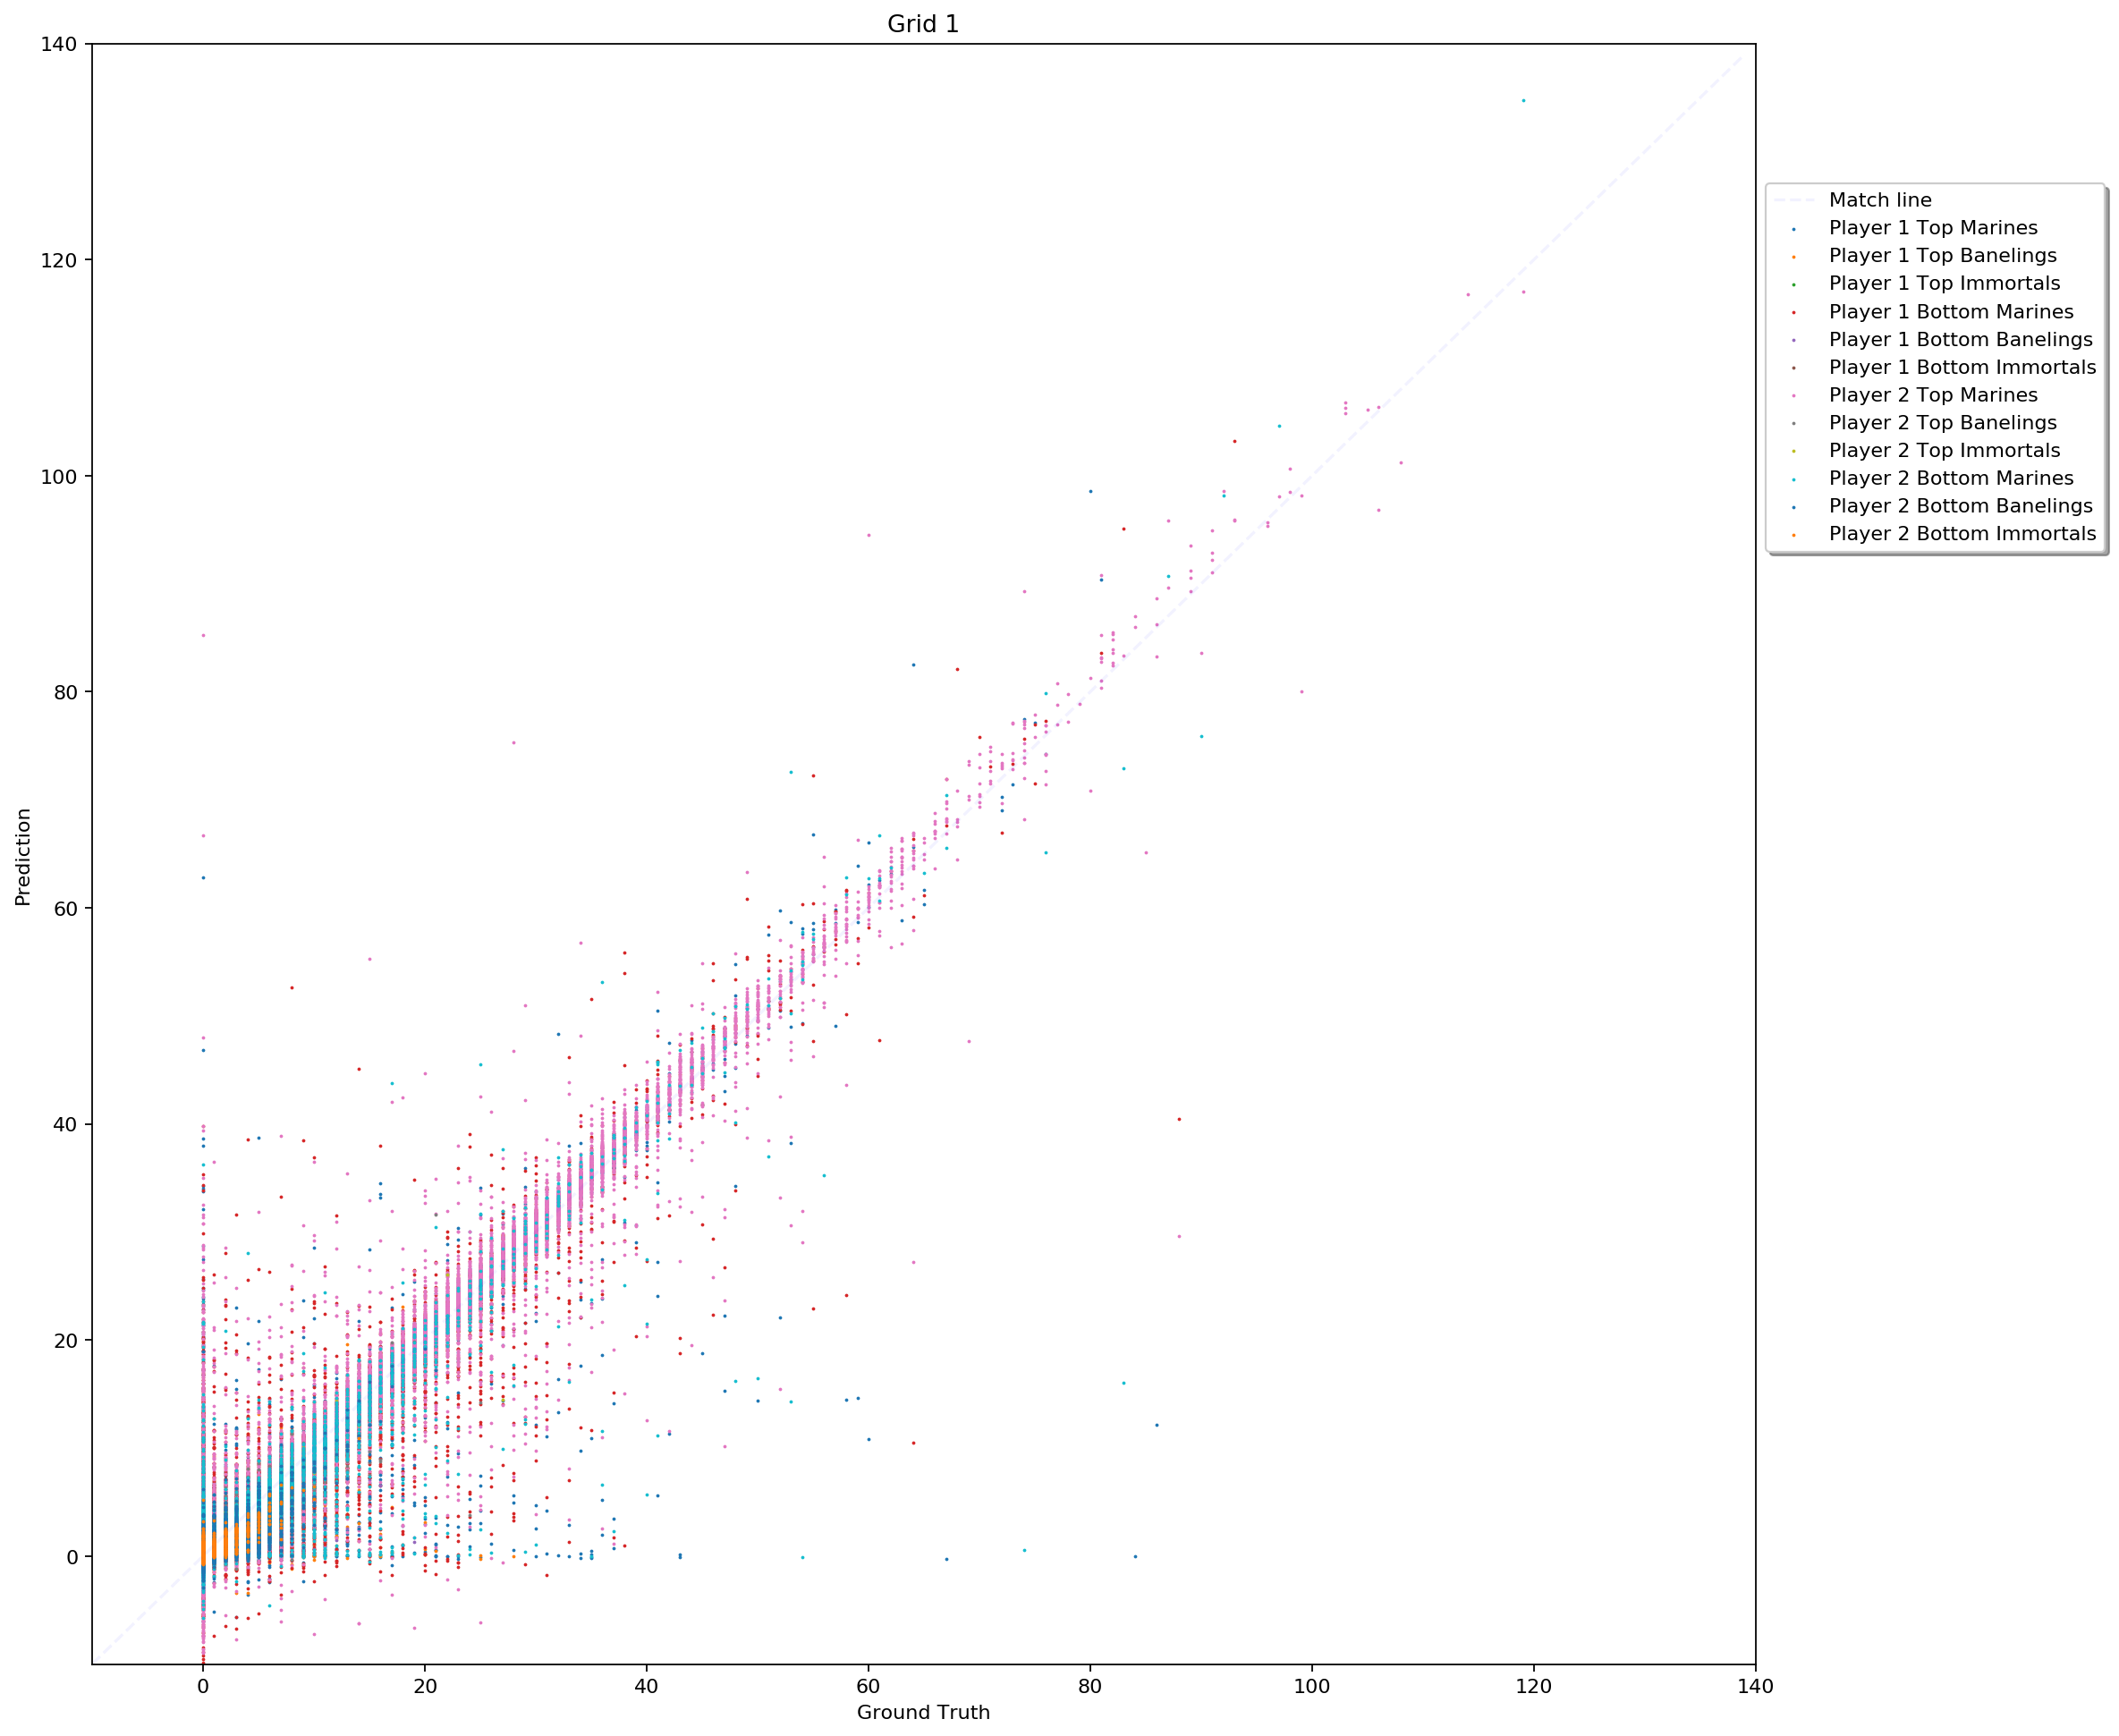

99810 99810


<Figure size 432x288 with 0 Axes>

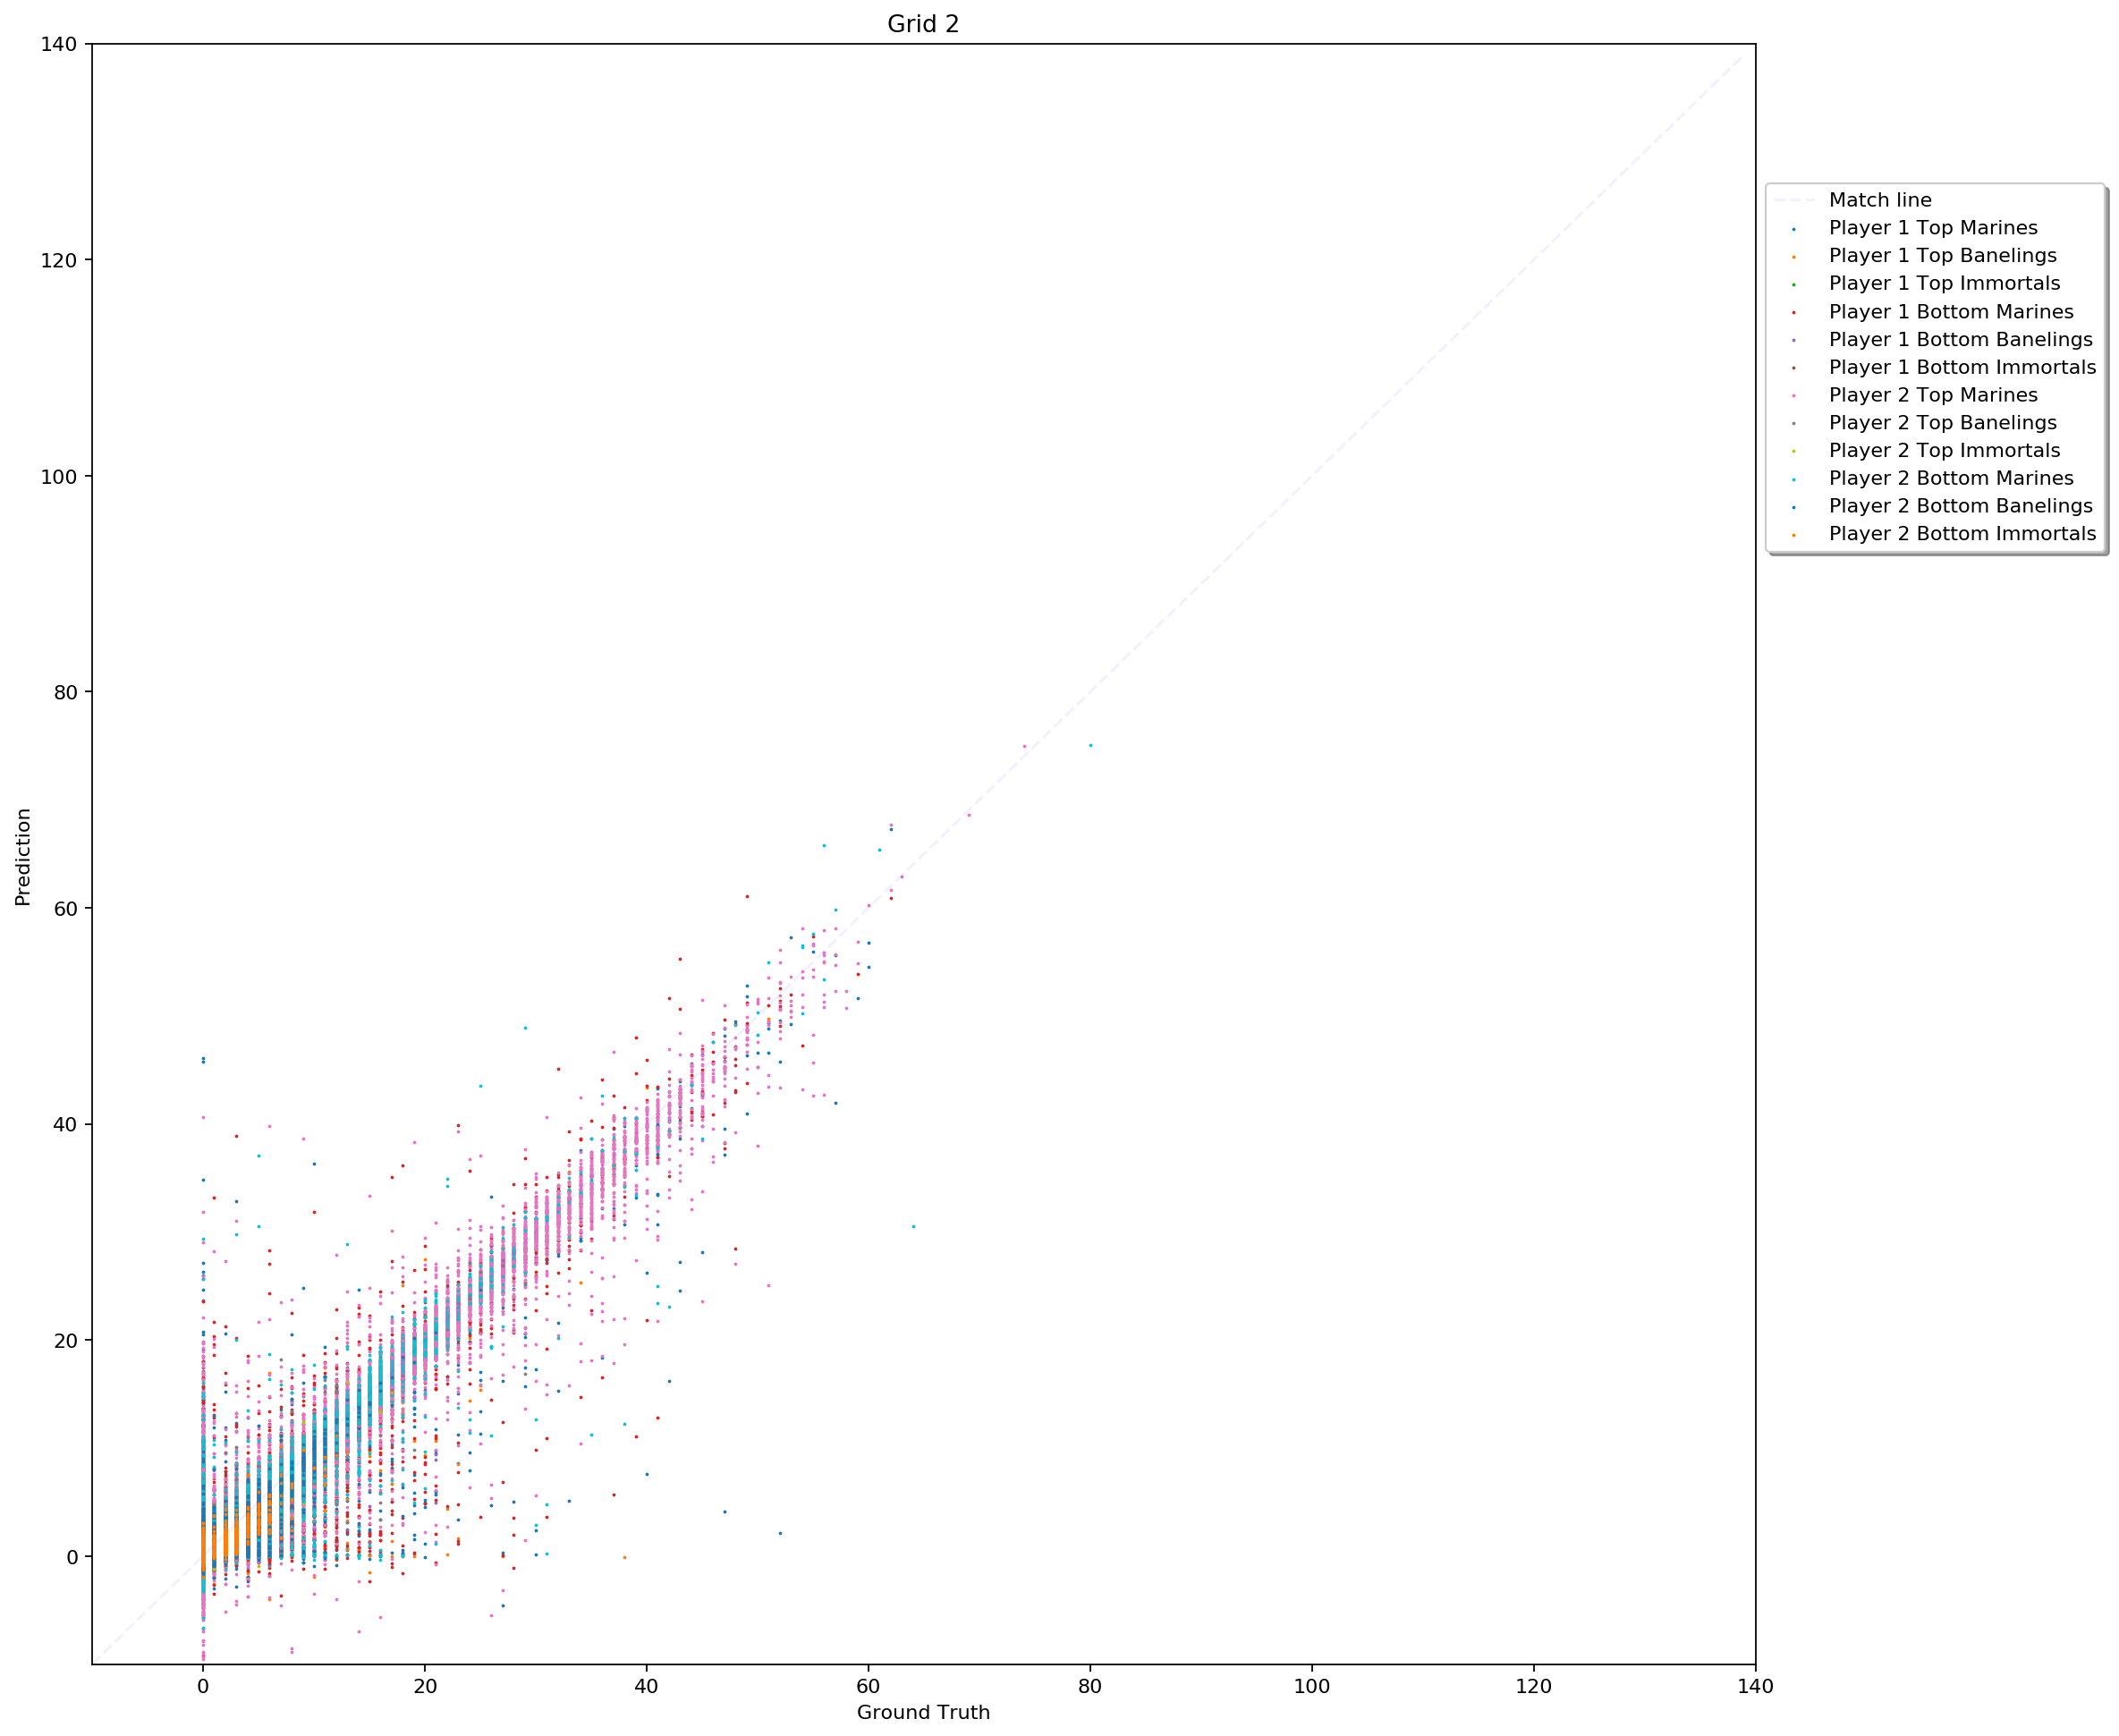

99810 99810


<Figure size 432x288 with 0 Axes>

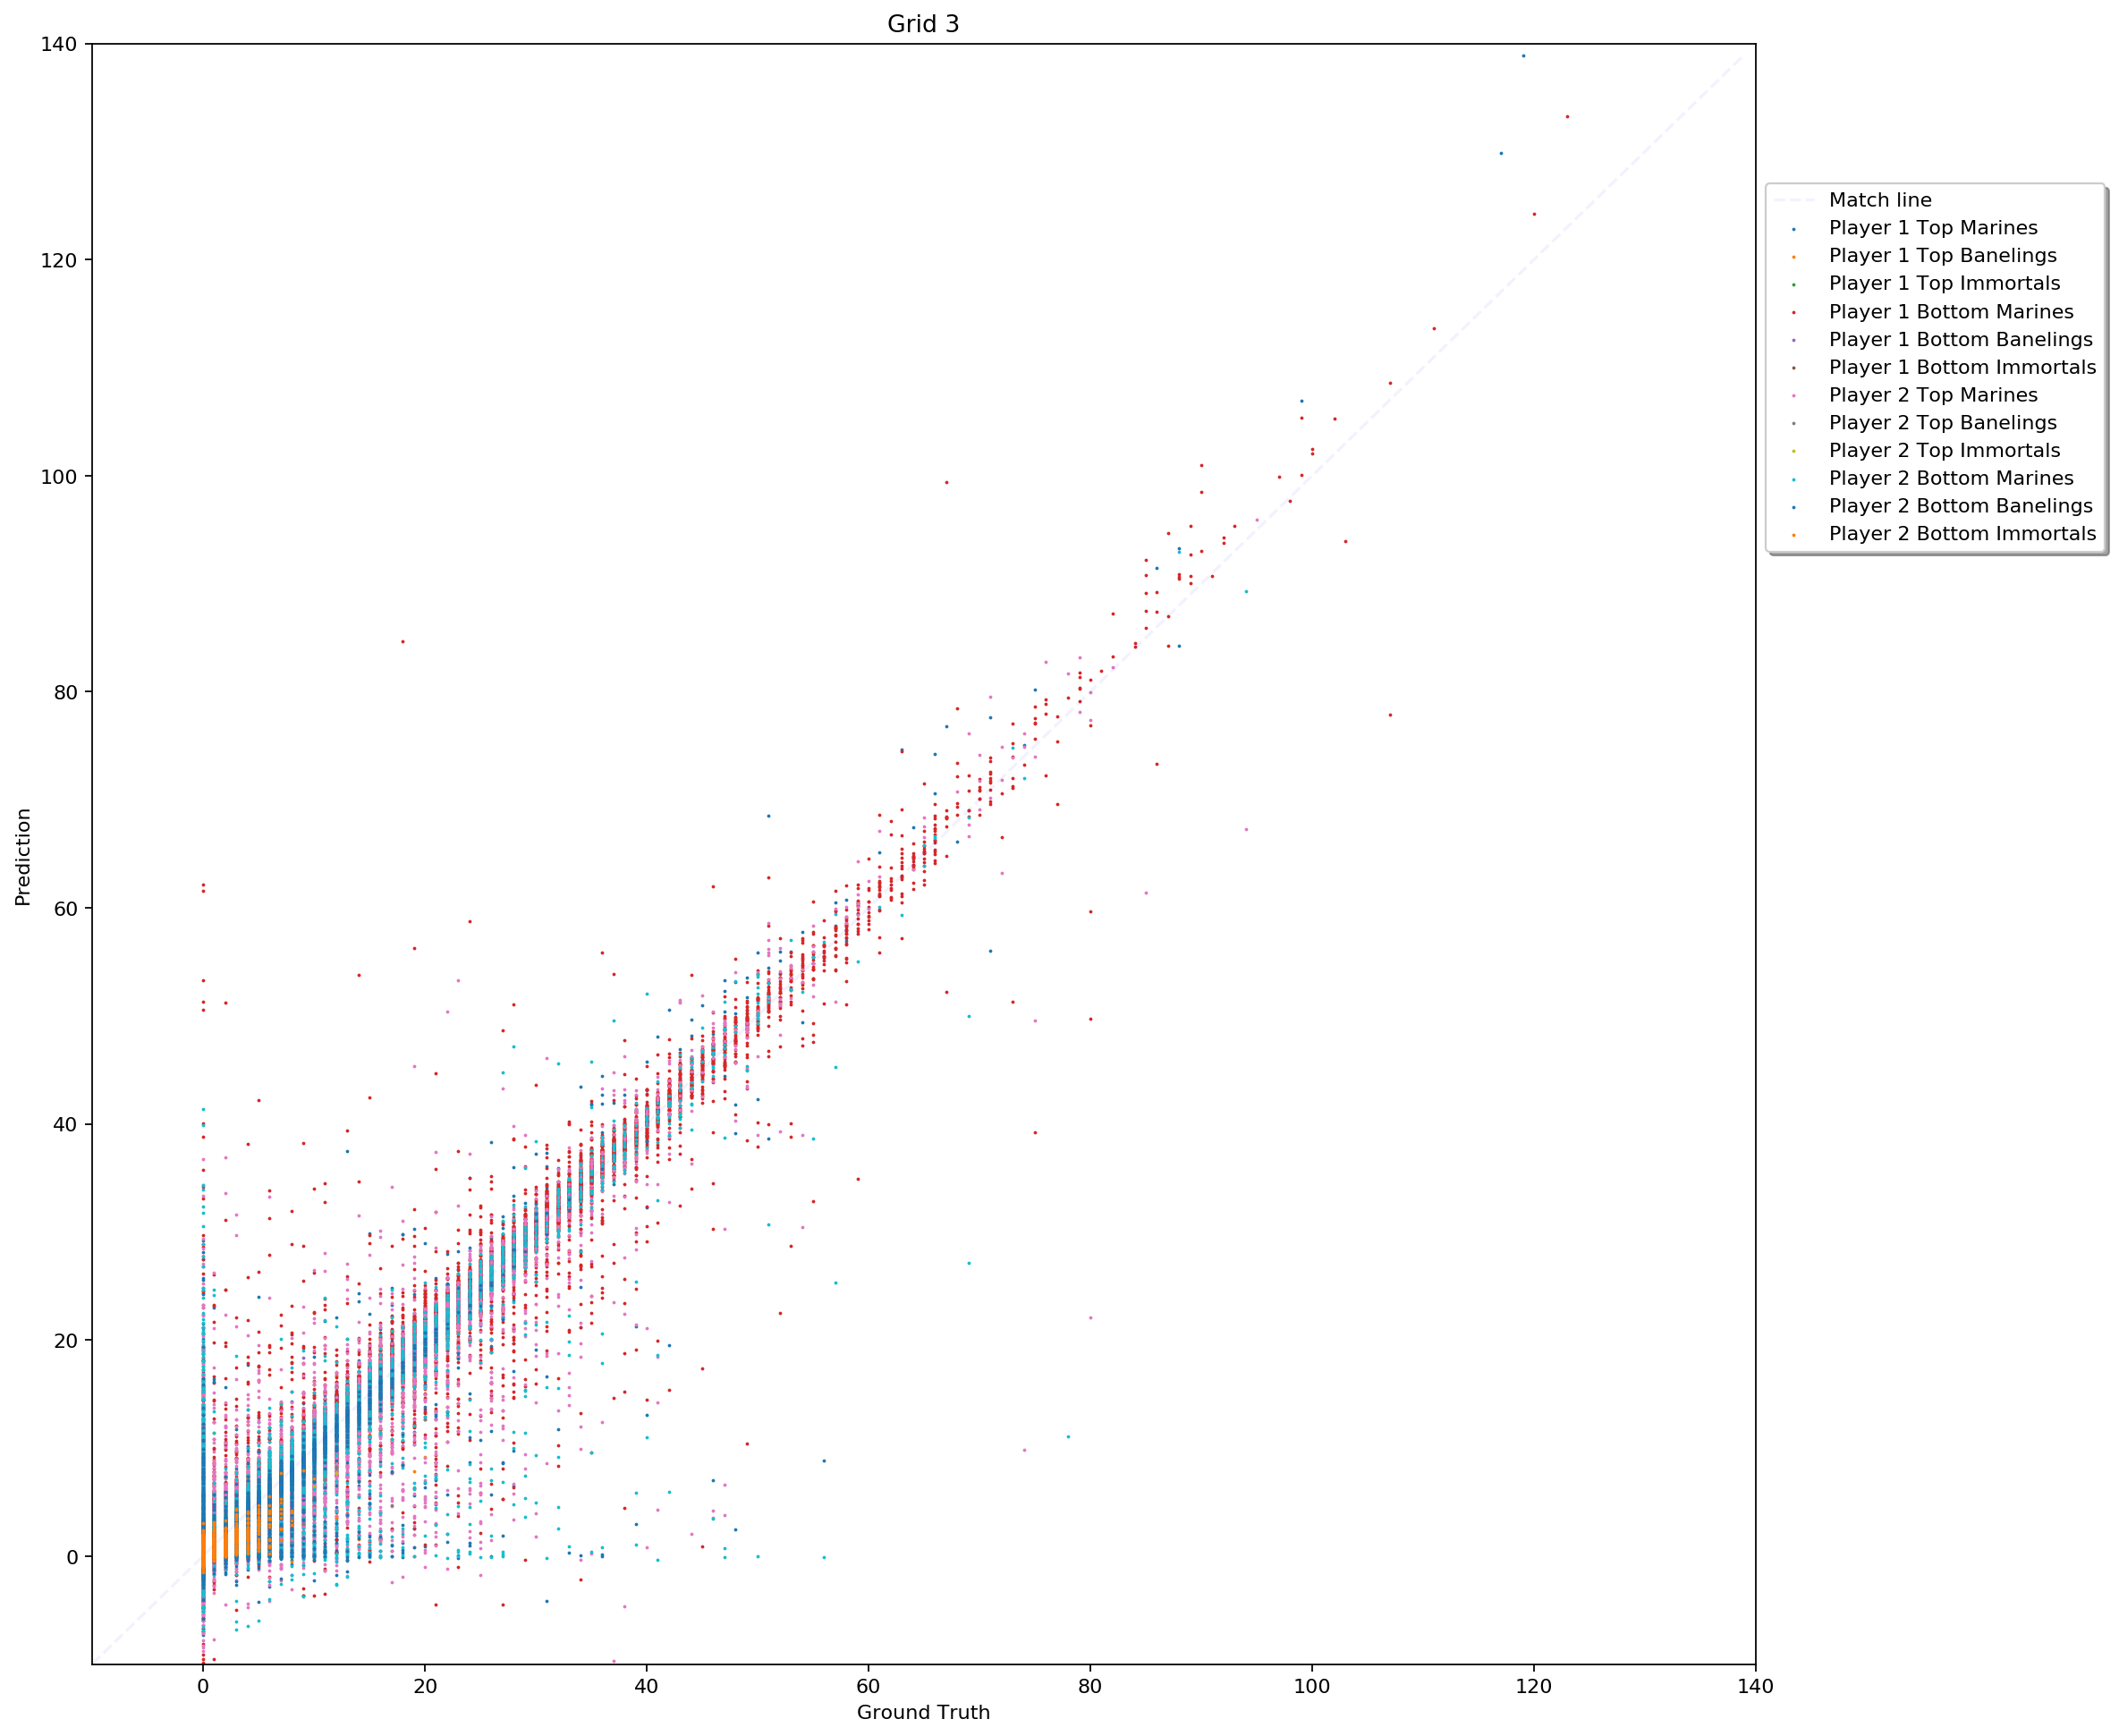

99810 99810


<Figure size 432x288 with 0 Axes>

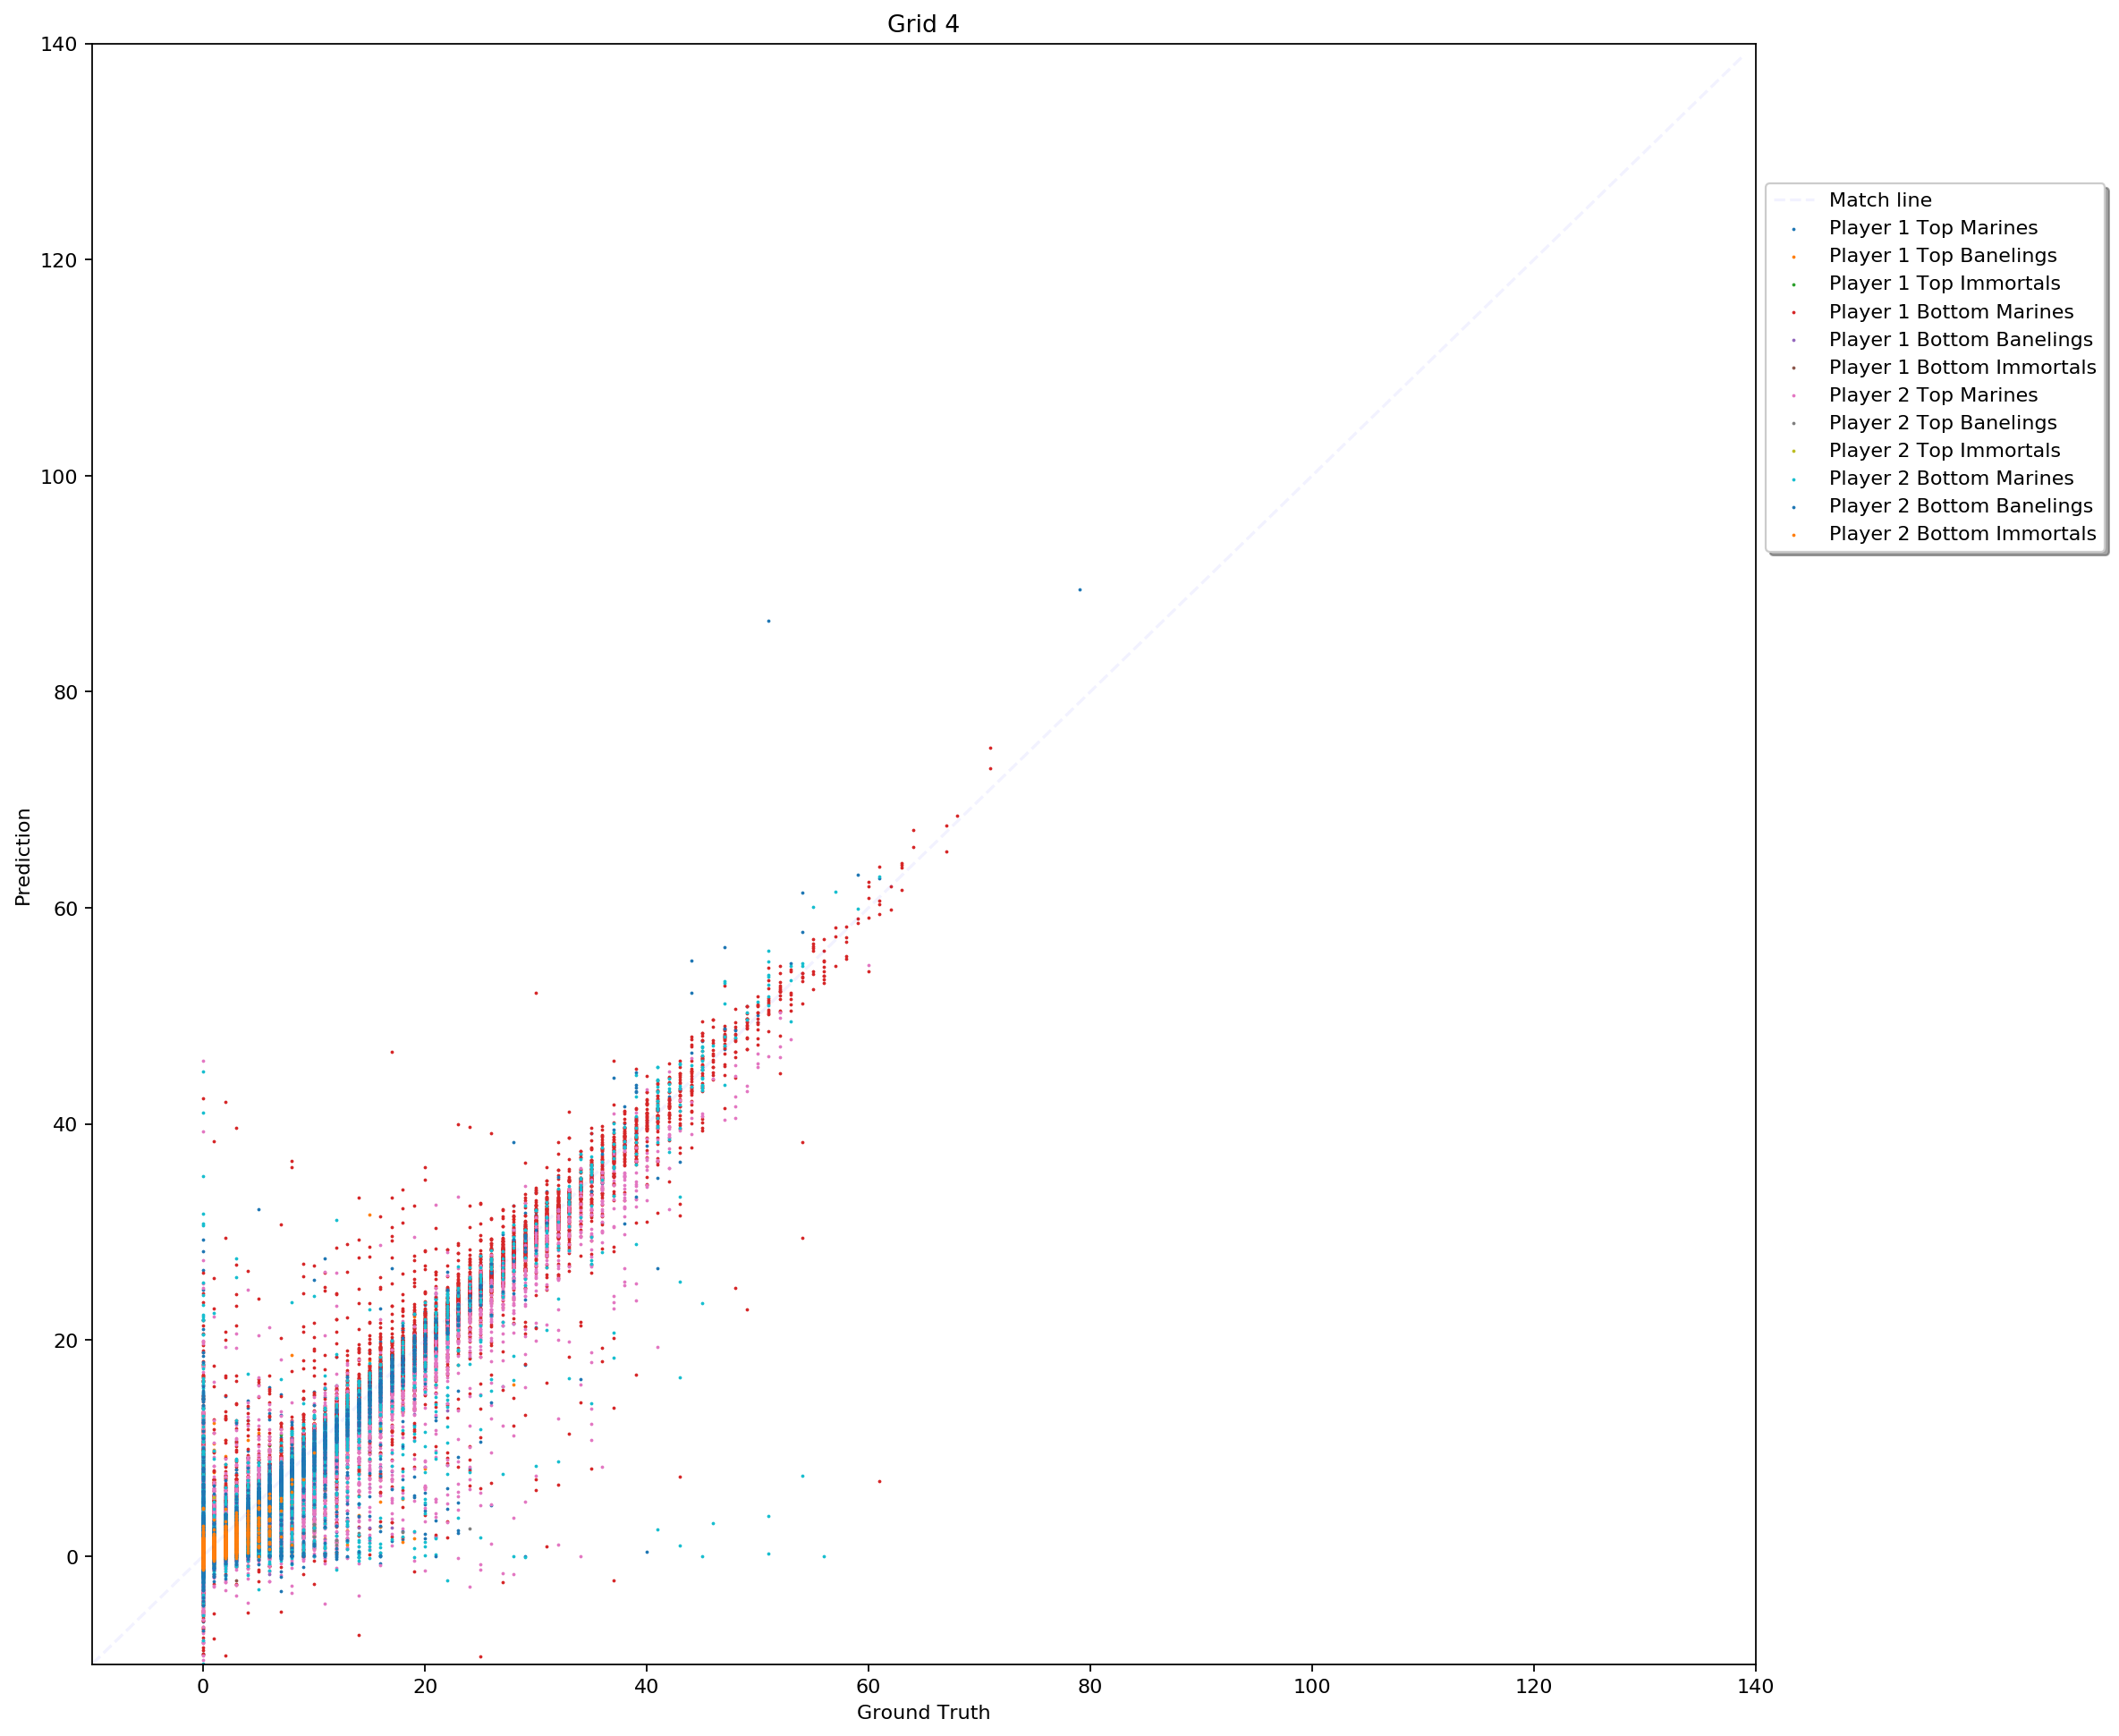

0.5110048651695251

In [20]:
check_model = TransModel(len(data[0][0]), len(data[0][1]))

check_model.model.load_state_dict(torch.load('./models_mb/units-transition-model-predict-4.pt'))

evaluation(check_model, test_data, 0)